In [185]:
from moku.instruments import LaserLockBox
import matplotlib.pyplot as plt
import numpy as np

In [186]:
LLB = LaserLockBox('192.168.50.63', force_connect=True, platform_id=4) #192.168.50.63 is the IP address for Moku pro 4

In [187]:
LLB.set_frontend(1, "AC", "50Ohm", "0dB")
LLB.set_frontend(2, "DC", "1MOhm", "0dB")

{'attenuation': '0dB', 'coupling': 'DC', 'impedance': '1MOhm'}

In [188]:
LLB.set_demodulation(mode="Modulation",frequency=50e6,phase=260)

{'frequency': 1000000.0, 'phase': 260.0, 'source': 'Modulation'}

In [189]:
LLB.set_output_limit(channel=1, low_limit=-1, high_limit=1)
LLB.set_output(1, signal=False, output=True)

{'gain_range': '0dB', 'output': True, 'signal': False}

In [190]:
LLB.set_monitor(1, 'ErrorSignal')
LLB.set_monitor(2, 'Input2')
LLB.set_acquisition_mode(mode="Precision")

{'mode': 'Precision'}

In [191]:
LLB.set_pid_by_frequency(channel=1,  int_crossover = 18e3, int_saturation = 40.0,prop_gain = 0)
print(LLB.summary())

Moku:Pro Laser Lock Box
Input 1, AC coupling, 50 Ohm impedance, 0 dB attenuation, 0 dB gain
Input 2, DC coupling, 1 MOhm impedance, 0 dB attenuation
Demodulating using modulation signal, phase shift 260.000 000 deg
Lowpass filter: 4th-order Butterworth Lowpass, corner frequency 1.000 MHz, sampling rate 78.125 MHz
Setpoint: 0.000 0 V
Fast controller: PI controller: proportional gain +0.0 dB, integrator crossover 18.00 kHz, integrator saturation +40.0 dB, invert off
Slow controller: PI controller: proportional gain -10.0 dB, integrator crossover 49.00 Hz, integrator saturation +40.0 dB, invert off
Scan - Positive ramp, 10.000 000 Hz, 500 mVpp, Output 1
Modulation - 1.000 000 000 000 MHz, 500 mVpp, off
Output 1 - control signal disabled, offset 0.000 0 V, limits disabled, 0 dB output gain, output enabled
Output 2 - control signal disabled, offset 0.000 0 V, limits disabled, 0 dB output gain, output disabled
Internal 10 MHz clock


In [192]:
LLB.set_scan_oscillator(enable=True,amplitude = 0.5, frequency = 100, output ="Output1",shape =  "PositiveRamp")

{'amplitude': 0.5,
 'enabled': True,
 'frequency': 100.0,
 'output': 'Output1',
 'shape': 'PositiveRamp'}

In [202]:
LLB.set_trigger(type="Edge", source="Scan", level=0)

{'edge': 'Rising',
 'hf_reject': False,
 'holdoff': 0.0,
 'hysteresis': 0.001,
 'level': 0.0,
 'noise_reject': False,
 'nth_event': 1}

In [204]:
LLB.set_timebase(0, 0.002)
LLB.set_output_offset(1, offset=0.4)
data = LLB.get_data(wait_complete=True)
data.keys()

dict_keys(['ch1', 'ch2', 'ch3', 'ch4', 'time'])

Text(0.5, 0, 'time (ms)')

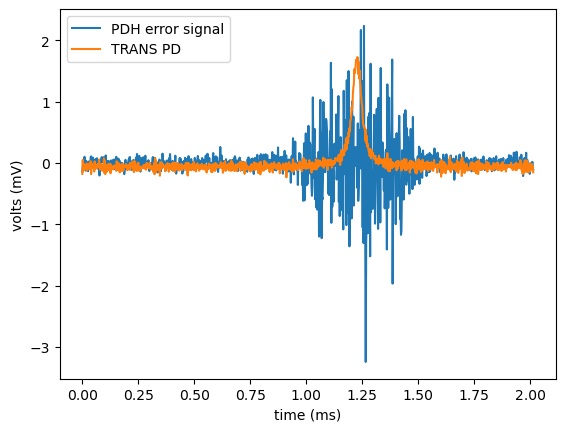

In [205]:
t = np.array(data['time'])*1e3
err = np.array(data['ch1'])*1e3
trans = np.array(data['ch2']-np.average(data['ch2']))*1e3

plt.plot(t,err)
plt.plot(t,trans)
plt.legend(['PDH error signal','TRANS PD'])
plt.ylabel('volts (mV)')
plt.xlabel('time (ms)')


In [196]:
LLB.relinquish_ownership()